In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple

# Define map elements
EMPTY = 0
WALL = 1
LAVA = 2
TREASURE = 3
EXIT = 4
START = 5
ENEMY = 6

# Define Colors for Visualization
COLOR_MAP = {
    EMPTY: "white",
    WALL: "brown",
    LAVA: "red",
    TREASURE: "yellow",
    EXIT: "green",
    START: "blue",
    ENEMY: "purple",
}

# Experience replay buffer
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)
        states = torch.stack([torch.tensor(e.state, dtype=torch.float) for e in experiences])
        actions = torch.tensor([e.action for e in experiences])
        rewards = torch.tensor([e.reward for e in experiences], dtype=torch.float)
        next_states = torch.stack([torch.tensor(e.next_state, dtype=torch.float) for e in experiences])
        dones = torch.tensor([e.done for e in experiences], dtype=torch.float)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQNModel(nn.Module):
    """Lightweight Q-Network"""
    def __init__(self, input_dim, output_dim):
        super(DQNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class DungeonAgent:
    """Agent that learns to generate levels"""
    def __init__(self, state_size, action_size, seed=42):
        self.state_size = state_size
        self.action_size = action_size

        random.seed(seed)
        torch.manual_seed(seed)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.qnetwork = DQNModel(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=0.001)
        self.memory = ReplayBuffer(5000)

        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.999995
        self.epsilon_min = 0.000001

    def act(self, state, eval_mode=False):
        if not eval_mode and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)

        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze(0)
        with torch.no_grad():
            action_values = self.qnetwork(state)

        if eval_mode and random.random() < 0.2:
            return random.randint(0, self.action_size - 1)

        return torch.argmax(action_values).item()

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.learn(self.memory.sample(self.batch_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        Q_expected = self.qnetwork(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        Q_targets = rewards + (self.gamma * self.qnetwork(next_states).max(1)[0] * (1 - dones))

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [ ]:
class DungeonEnvironment:
    def __init__(self, difficulty=5, board_size=20):
        self.board_size = board_size
        self.difficulty = difficulty
        self.max_enemies = 4

        self.element_types = [EMPTY, WALL, LAVA, TREASURE, EXIT, START, ENEMY]
        self.placement_types = [LAVA, TREASURE, ENEMY, WALL, EMPTY]

        self.grid = np.zeros((board_size, board_size), dtype=np.int8)
        self.cursor = None
        self.start_pos = None
        self.exit_pos = None
        self.steps = 0
        self.max_steps = 400

        self._setup_playable_area()

    def _setup_playable_area(self):
        """Define and fill the playable area based on difficulty."""
        # Scale playable area size with difficulty
        min_playable = 5
        max_playable = 18
        playable_size = min_playable + (self.difficulty - 1) * (max_playable - min_playable) // 9
        self.playable_width = self.playable_height = playable_size

        # Center the playable area
        self.playable_start_x = (self.board_size - self.playable_width) // 2
        self.playable_start_y = (self.board_size - self.playable_height) // 2
        self.playable_end_x = self.playable_start_x + self.playable_width - 1
        self.playable_end_y = self.playable_start_y + self.playable_height - 1

        self.object_counts = {k: 0 for k in self.placement_types}

    def reset(self):
        self.grid = np.zeros((self.board_size, self.board_size), dtype=int)
        self.steps = 0
        self._setup_playable_area()

        # Fill outer area with walls
        for y in range(self.board_size):
            for x in range(self.board_size):
                if (
                    x < self.playable_start_x or x > self.playable_end_x or
                    y < self.playable_start_y or y > self.playable_end_y
                ):
                    self.grid[y][x] = WALL

        # Place START and EXIT inside playable area
        positions = [
            (x, y)
            for y in range(self.playable_start_y + 1, self.playable_end_y)
            for x in range(self.playable_start_x + 1, self.playable_end_x)
        ]
        self.start_pos = random.choice(positions)
        positions.remove(self.start_pos)
        self.exit_pos = random.choice(positions)

        self.grid[self.start_pos[1]][self.start_pos[0]] = START
        self.grid[self.exit_pos[1]][self.exit_pos[0]] = EXIT

        self.cursor = list(self.start_pos)
        self.object_counts = {k: 0 for k in self.placement_types}
        self.visited = {tuple(self.cursor)}

        # Determine playable interior area
        playable_area = (self.playable_width - 2) * (self.playable_height - 2)

        # ✅ New logic for treasure limit
        max_treasure = max(1, int(0.25 * (playable_area ** 0.5)) - (self.difficulty // 2))
        max_treasure = min(max_treasure, 10)

        # ✅ Lava and wall density updates
        lava_density = 0.01 + 0.005 * self.difficulty
        wall_density = 0.2 + 0.02 * self.difficulty

        max_lava = int(playable_area * lava_density)
        max_internal_walls = int(playable_area * wall_density)

        # ✅ Enemy tier rules (already implemented)
        if self.difficulty <= 4:
            self.allowed_enemy_limit = 1
        elif self.difficulty <= 7:
            self.allowed_enemy_limit = random.randint(2, 3)
        else:
            self.allowed_enemy_limit = 5

        # Place objects
        self._place_random_objects(TREASURE, max_treasure)
        self._place_random_objects(LAVA, max_lava)
        self._place_random_objects(ENEMY, self.allowed_enemy_limit)
        self._place_random_objects(WALL, max_internal_walls)


        return self._get_state()



    def _place_random_objects(self, tile, count):
        attempts = 0
        placed = 0
        max_attempts = count * 10

        while placed < count and attempts < max_attempts:
            x = random.randint(self.playable_start_x + 1, self.playable_end_x - 1)
            y = random.randint(self.playable_start_y + 1, self.playable_end_y - 1)

            if (x, y) not in [self.start_pos, self.exit_pos] and self.grid[y][x] == EMPTY:
                self.grid[y][x] = tile
                placed += 1
                if tile in self.object_counts:
                    self.object_counts[tile] += 1

            attempts += 1


    def step(self, action):
        self.steps += 1
        reward = 0
        done = False

        if action < 4:
            # Movement: up, down, left, right
            dx, dy = [(0, -1), (0, 1), (-1, 0), (1, 0)][action]
            new_x = min(max(self.cursor[0] + dx, self.playable_start_x + 1), self.playable_end_x - 1)
            new_y = min(max(self.cursor[1] + dy, self.playable_start_y + 1), self.playable_end_y - 1)
            self.cursor = [new_x, new_y]
            reward -= 0.1  # discourage wandering
        else:
            tile = self.placement_types[action - 4]
            cx, cy = self.cursor
            current_tile = self.grid[cy][cx]

            if (cx, cy) not in [self.start_pos, self.exit_pos]:
                # Adjust old object count
                if current_tile in self.object_counts:
                    self.object_counts[current_tile] = max(0, self.object_counts[current_tile] - 1)

                self.grid[cy][cx] = tile

                # Apply tile placement logic
                if tile == WALL:
                    self.object_counts[WALL] += 1
                    reward += 2
                elif tile == TREASURE:
                    self.object_counts[TREASURE] += 1
                    reward += 3
                elif tile == ENEMY:
                    self.object_counts[ENEMY] += 1

                    # ✅ Enforce enemy limit
                    if self.object_counts[ENEMY] > self.allowed_enemy_limit:
                        reward -= 10  # Heavy penalty
                    else:
                        reward += 4
                elif tile == LAVA:
                    self.object_counts[LAVA] += 1
                    reward += 2
                elif tile == EMPTY:
                    reward -= 1

        if self.steps >= self.max_steps:
            done = True
            reward += self._calculate_path_complexity() * 30

        return self._get_state(), reward, done


    def _get_state(self):
        one_hot = np.zeros((self.board_size, self.board_size, len(self.element_types)), dtype=np.float32)
        for y in range(self.board_size):
            for x in range(self.board_size):
                tile = self.grid[y][x]
                one_hot[y, x, tile] = 1
        flat = one_hot.flatten()
        normalized_cursor = [self.cursor[0] / self.board_size, self.cursor[1] / self.board_size]
        return np.concatenate([flat, normalized_cursor])

    def _calculate_path_complexity(self):
        """Estimate complexity based on path length from START to EXIT"""
        visited = np.zeros((self.board_size, self.board_size), dtype=bool)
        queue = [(self.start_pos, 0)]
        visited[self.start_pos[1], self.start_pos[0]] = True
        path_lengths = []

        while queue:
            (x, y), dist = queue.pop(0)
            if (x, y) == self.exit_pos:
                path_lengths.append(dist)
                continue

            for dx, dy in [(0, -1), (1, 0), (0, 1), (-1, 0)]:
                nx, ny = x + dx, y + dy
                if (self.playable_start_x <= nx <= self.playable_end_x and
                    self.playable_start_y <= ny <= self.playable_end_y and
                    not visited[ny, nx] and self.grid[ny][nx] != WALL):
                    visited[ny, nx] = True
                    queue.append(((nx, ny), dist + 1))

        if not path_lengths:
            return 0

        avg_path_length = sum(path_lengths) / len(path_lengths)
        return avg_path_length / (self.playable_width + self.playable_height)


In [ ]:
def train_dungeon_generator(num_episodes=1000, model_path="dungeon_rl_model.pth"):
    """Train a single RL model to generate levels for all difficulties."""
    envs = {d: DungeonEnvironment(d) for d in range(1, 11)}  # One environment per difficulty

    tile_types = len(envs[1].element_types)
    grid_size = 20 * 20
    state_size = grid_size * tile_types + 2  # One-hot grid + cursor
    action_size = 9  # 4 move + 5 place

    agent = DungeonAgent(state_size=state_size, action_size=action_size)

    for episode in range(num_episodes):
        difficulty = random.randint(1, 10)
        env = envs[difficulty]
        state = env.reset()
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state

        if episode % 50 == 0:
            print(f"Episode {episode}, Epsilon: {agent.epsilon:.3f}, Difficulty: {difficulty}")

    torch.save(agent.qnetwork.state_dict(), model_path)
    print(f"Model saved to: {model_path}")

    return agent, envs


def generate_dungeon_with_model(agent, difficulty):
    """Generate a level using a trained RL model with added randomness."""
    env = DungeonEnvironment(difficulty)
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state, eval_mode=True)

        if random.random() < 0.2:
            action = random.randint(0, 8)  # Explore randomly

        state, _, done = env.step(action)

    return env.grid


def visualize_dungeon(grid):
    """Display dungeon grid using matplotlib."""
    fig, ax = plt.subplots(figsize=(6, 6))
    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            rect = plt.Rectangle(
                (x, grid.shape[0] - y - 1), 1, 1,
                facecolor=COLOR_MAP[grid[y, x]],
                edgecolor='black'
            )
            ax.add_patch(rect)

    ax.set_xlim(0, grid.shape[1])
    ax.set_ylim(0, grid.shape[0])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title("Generated Dungeon")
    plt.show()

In [ ]:
def load_trained_agent(model_path="/content/drive/MyDrive/FAI/dungeon_rl_model.pth"):
    """Load the trained model weights into a new agent."""
    grid_size = 20 * 20
    tile_types = len(COLOR_MAP)  # safer than hardcoding 7
    state_size = grid_size * tile_types + 2  # one-hot grid + cursor
    action_size = 9  # 4 move + 5 place

    agent = DungeonAgent(state_size=state_size, action_size=action_size)
    agent.qnetwork.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    agent.qnetwork.eval()

    print(f"Model loaded from: {model_path}")
    return agent


In [11]:
# Dropout
# Train and Visualize
if __name__ == "__main__":
    trained_agent, trained_envs = train_dungeon_generator(num_episodes=500)
    generated_dungeon = generate_dungeon_with_model(trained_agent, 7)
    visualize_dungeon(generated_dungeon)

KeyboardInterrupt: 

Difficulty: 10


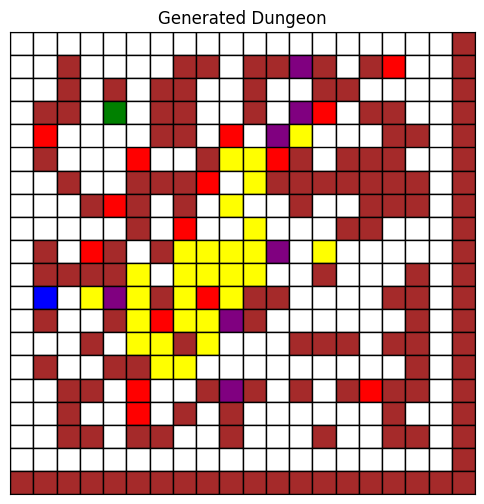

In [10]:
difficulty = 10
print(f"Difficulty: {difficulty}")
generated_dungeon = generate_dungeon_with_model(trained_agent, difficulty)
visualize_dungeon(generated_dungeon)

Model loaded from: /content/drive/MyDrive/FAI/dungeon_rl_model.pth
Difficulty: 8


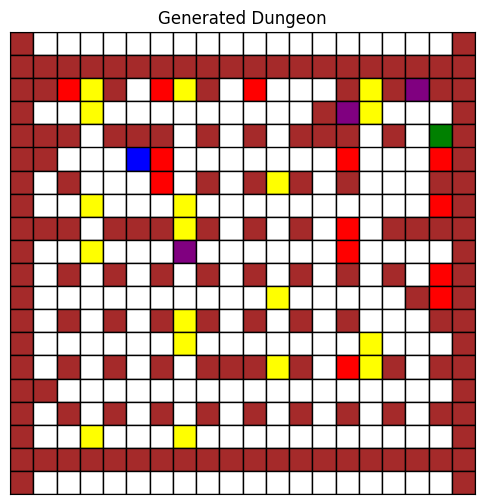

In [ ]:
# Load model before generating dungeons
agent = load_trained_agent("/content/drive/MyDrive/FAI/dungeon_rl_model.pth")  # Ensure same architecture

# Generate dungeon using the loaded model
difficulty = 8
print(f"Difficulty: {difficulty}")
generated_dungeon = generate_dungeon_with_model(agent, difficulty)
visualize_dungeon(generated_dungeon)